In [12]:
import pandas as pd
import numpy as np
import re

## setup

In [13]:
def check_consistency(options):
    valid_options = {'A', 'B', 'C', 'D', 'E','F'}
        # Check if all options are long strings (length greater than 10)
    if all(len(option.strip()) > 30 for option in options):
        return True
    # Remove special characters and convert to uppercase
    cleaned_options = [re.sub(r'[^a-zA-Z0-9\s]', '', option).strip().upper() for option in options]
    
    # Check if all cleaned options start with the same valid option letter or are long strings
    first_chars = set(option[0] for option in cleaned_options)
    if len(first_chars) == 1 and (first_chars.pop() in valid_options and all(len(option) < 40 for option in cleaned_options)):
        return True
    
    # Check if all cleaned options are identical
    if len(set(cleaned_options)) == 1:
        return True
    return False

def map_category_to_broad(category):
    if category in ['philosophy', 'jurisprudence', 'international_law', 'professional_law', 'business_ethics']:
        return 'Law & Philosophy'
    elif category in ['college_chemistry', 'college_medicine', 'college_physics', 'college_biology']:
        return 'Natural Science'
    elif category in ['Math', 'high_school_statistics', 'date_understanding', 'elementary_mathematics']:
        return 'Elementary Math'
    elif category in ['Challenging Math', 'college_mathematics', 'abstract_algebra', 'formal_logic']:
        return 'Advanced Math'
    else:
        return 'Applied Science'
    
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def check_consistency_pair(option1, option2):
    return check_consistency([option1,option2])

import os

def calculate_accuracy_and_plot_confusion_matrix_for_category(df, category_col, correct_answer_col, raw_cot_col, corrected_cot_col, output_dir):
    """
    Calculate confusion matrix components and accuracy rates for each broad category, 
    then plot the confusion matrix and save it as a PNG file.
    
    Parameters:
    - df: DataFrame containing the dataset.
    - category_col: String name of the column with the broad categories.
    - correct_answer_col: String name of the column with the correct answers.
    - raw_cot_col: String name of the column with the raw COT answers.
    - corrected_cot_col: String name of the column with the corrected COT answers.
    - output_dir: String path to the directory where the confusion matrix images will be saved.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    
    categories = df[category_col].unique()
    
    for category in categories:
        print(f"\nCategory: {category}")
        df_category = df[df[category_col] == category]
        
        # Calculate confusion matrix components
        TP = df_category.apply(lambda x: check_consistency_pair(x[raw_cot_col], x[correct_answer_col]) and check_consistency_pair(x[corrected_cot_col], x[raw_cot_col]), axis=1).sum()
        TN = df_category.apply(lambda x: not check_consistency_pair(x[raw_cot_col], x[correct_answer_col]) and check_consistency_pair(x[corrected_cot_col], x[correct_answer_col]), axis=1).sum()
        FN = df_category.apply(lambda x: not check_consistency_pair(x[raw_cot_col], x[correct_answer_col]) and not check_consistency_pair(x[corrected_cot_col], x[correct_answer_col]), axis=1).sum()
        FP = df_category.apply(lambda x: check_consistency_pair(x[raw_cot_col], x[correct_answer_col]) and not check_consistency_pair(x[corrected_cot_col], x[correct_answer_col]), axis=1).sum()

        # Calculate accuracy rates
        filter_accuracy = df_category.apply(
            lambda row: check_consistency([row["Correct Answer"], row["Raw COT Answer"]]), 
            axis=1
        ).sum() / len(df_category) 
        pipeline_accuracy = df_category.apply(
            lambda row: check_consistency([row["Correct Answer"], row["Corrected COT Answer"]]), 
            axis=1
        ).sum() / len(df_category) 

        # Print accuracy rates
        print(f"Filter Accuracy: {filter_accuracy:.2f}")
        print(f"Pipeline Accuracy: {pipeline_accuracy:.2f}")

        # Construct and plot the confusion matrix
        conf_matrix = [[TP, FP], [FN, TN]]
        plt.figure()
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative'], yticklabels=['Actual Positive', 'Actual Negative'])
        plt.title(f'Confusion Matrix for {category}')
        plt.tight_layout()
        
        # Save the confusion matrix as a PNG file
        output_path = os.path.join(output_dir, f"confusion_matrix_{category}.png")
        plt.savefig(output_path)
        plt.close()
    
    TP = df.apply(lambda x: check_consistency_pair(x[raw_cot_col], x[correct_answer_col]) and check_consistency_pair(x[corrected_cot_col], x[raw_cot_col]), axis=1).sum()
    TN = df.apply(lambda x: not check_consistency_pair(x[raw_cot_col], x[correct_answer_col]) and check_consistency_pair(x[corrected_cot_col], x[correct_answer_col]), axis=1).sum()
    FN = df.apply(lambda x: not check_consistency_pair(x[raw_cot_col], x[correct_answer_col]) and not check_consistency_pair(x[corrected_cot_col], x[correct_answer_col]), axis=1).sum()
    FP = df.apply(lambda x: check_consistency_pair(x[raw_cot_col], x[correct_answer_col]) and not check_consistency_pair(x[corrected_cot_col], x[correct_answer_col]), axis=1).sum()

    # Calculate accuracy rates
    filter_accuracy = df.apply(
        lambda row: check_consistency([row["Correct Answer"], row["Raw COT Answer"]]), 
        axis=1
    ).sum() / len(df) 
    pipeline_accuracy = df.apply(
        lambda row: check_consistency([row["Correct Answer"], row["Corrected COT Answer"]]), 
        axis=1
    ).sum() / len(df) 

    # Print accuracy rates
    print(f"Filter Accuracy: {filter_accuracy}")
    print(f"Pipeline Accuracy: {pipeline_accuracy}")

    # Construct and plot the confusion matrix
    conf_matrix = [[TP, FP], [FN, TN]]
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative'], yticklabels=['Actual Positive', 'Actual Negative'])
    plt.title('Confusion Matrix')
    plt.tight_layout()
    
    # Save the confusion matrix as a PNG file
    output_path = os.path.join(output_dir, "confusion_matrix_overall.png")
    plt.savefig(output_path)
    plt.close()

    return filter_accuracy, pipeline_accuracy

def get_confidence_score_filter(consistency, similarity, steps, alpha=0.5, beta=0.5, gamma=0.5):
    C_steps = math.exp(-alpha * steps)
    
    C_sim = similarity
    
#     C_debates = math.exp(-beta * (debates / max_debates))
    
#     C_hallucination = math.exp(-gamma * (sum(hallu_steps) / steps))
    
    C = (int(consistency)+C_steps + C_sim) / 3
    
    return C


def get_confidence_score(hallu_steps, prior_cs, debates, max_debates=2, alpha=0.5, beta=0.5, gamma=0.5):
#     C_steps = math.exp(-alpha * steps)
    
#     C_sim = similarity
    
    C_debates = math.exp(-beta * (debates / max_debates))
    
    C_hallucination = math.exp(-gamma * (hallu_steps) / steps)
    
    C = (prior_cs * 2 + C_debates + C_hallucination) / 4
    
    return C

In [14]:
df1 = pd.read_csv('result_Math_result.csv')
df2 = pd.read_csv('result_high_school_statistics_result.csv')
df3 = pd.read_csv('result_abstract_algebra_result.csv')
df4 = pd.read_csv('result_last_result.csv')
df4= df4[df4.Category=='date_understanding']
df_final = pd.concat([df1,df2,df3,df4])

df1 = pd.read_csv('../debate_stats/result_Math_debate.csv')
df2 = pd.read_csv('../debate_stats/result_high_school_statistics_debate.csv')
df3 = pd.read_csv('../debate_stats/result_abstract_algebra_debate.csv')
df4 = pd.read_csv('../debate_stats/result_last_debate.csv')
df4= df4[df4.Category=='date_understanding']
count_df = pd.concat([df1,df2,df3,df4])

df1 = pd.read_csv('df_final_no_debate.csv')
df1['Broad Category'] = df1['Category'].apply(map_category_to_broad)
df1 = df1[df1.Question!='Question']
df2 = pd.read_csv('df_final_no_judge.csv')
df2['Broad Category'] = df2['Category'].apply(map_category_to_broad)
df2 = df2[df2.Question!='Question']
df3 = pd.read_csv('df_final_whole_cot.csv')
df3['Broad Category'] = df3['Category'].apply(map_category_to_broad)
df3 = df3[df3.Question!='Question']

### Ablation study

In [15]:
calculate_accuracy_and_plot_confusion_matrix_for_category(df3, 'Broad Category', 'Correct Answer', 'Raw COT Answer', 'Corrected COT Answer','whole_cout/')


Category: Applied Science
Filter Accuracy: 0.52
Pipeline Accuracy: 0.48

Category: Elementary Math
Filter Accuracy: 0.78
Pipeline Accuracy: 0.67

Category: Advanced Math
Filter Accuracy: 0.62
Pipeline Accuracy: 0.60

Category: Law & Philosophy
Filter Accuracy: 0.37
Pipeline Accuracy: 0.37

Category: Natural Science
Filter Accuracy: 0.36
Pipeline Accuracy: 0.37
Filter Accuracy: 0.5311572700296736
Pipeline Accuracy: 0.5044510385756676


(0.5311572700296736, 0.5044510385756676)

In [16]:
calculate_accuracy_and_plot_confusion_matrix_for_category(df1, 'Broad Category', 'Correct Answer', 'Raw COT Answer', 'Corrected COT Answer','no_debate')


Category: Applied Science
Filter Accuracy: 0.52
Pipeline Accuracy: 0.54

Category: Elementary Math
Filter Accuracy: 0.78
Pipeline Accuracy: 0.61

Category: Advanced Math
Filter Accuracy: 0.62
Pipeline Accuracy: 0.67

Category: Law & Philosophy
Filter Accuracy: 0.37
Pipeline Accuracy: 0.34

Category: Natural Science
Filter Accuracy: 0.36
Pipeline Accuracy: 0.42
Filter Accuracy: 0.5311572700296736
Pipeline Accuracy: 0.5311572700296736


(0.5311572700296736, 0.5311572700296736)

In [17]:
calculate_accuracy_and_plot_confusion_matrix_for_category(df2, 'Broad Category', 'Correct Answer', 'Raw COT Answer', 'Corrected COT Answer','no_judge')


Category: Applied Science
Filter Accuracy: 0.35
Pipeline Accuracy: 0.43

Category: Elementary Math
Filter Accuracy: 0.43
Pipeline Accuracy: 0.53

Category: Advanced Math
Filter Accuracy: 0.48
Pipeline Accuracy: 0.59

Category: Law & Philosophy
Filter Accuracy: 0.31
Pipeline Accuracy: 0.41

Category: Natural Science
Filter Accuracy: 0.25
Pipeline Accuracy: 0.39
Filter Accuracy: 0.37317784256559766
Pipeline Accuracy: 0.48104956268221577


(0.37317784256559766, 0.48104956268221577)

## Main

In [18]:
df_temp = df_final

#### CoT Rerailer

In [19]:
# Assuming your DataFrame is named df
df_temp['Broad Category'] = df_temp['Category'].apply(map_category_to_broad)

In [11]:
# Example usage
calculate_accuracy_and_plot_confusion_matrix_for_category(df_temp, 'Broad Category', 'Correct Answer', 'Raw COT Answer', 'Corrected COT Answer','multi_step')

# Convert accuracy from boolean to integer (1 for True, 0 for False)
# df_temp["pipeline_accuracy"] = df_temp["pipeline_accuracy"].astype(int)


Category: Applied Science
Filter Accuracy: 0.52
Pipeline Accuracy: 0.62

Category: Elementary Math
Filter Accuracy: 0.78
Pipeline Accuracy: 0.67

Category: Advanced Math
Filter Accuracy: 0.62
Pipeline Accuracy: 0.68

Category: Law & Philosophy
Filter Accuracy: 0.37
Pipeline Accuracy: 0.41

Category: Natural Science
Filter Accuracy: 0.36
Pipeline Accuracy: 0.48
Filter Accuracy: 0.5311572700296736
Pipeline Accuracy: 0.5816023738872403


(0.5311572700296736, 0.5816023738872403)

### Baseline

In [21]:
df_filter = pd.read_csv('../debate_stats/confidence_score.csv')

In [22]:
df_filter = pd.read_csv('../debate_stats/confidence_score.csv')

/tmp/ipykernel_582434/3680818807.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Accuracy", y="Category", hue="Answer Type", data=accuracies_df, ci=None)


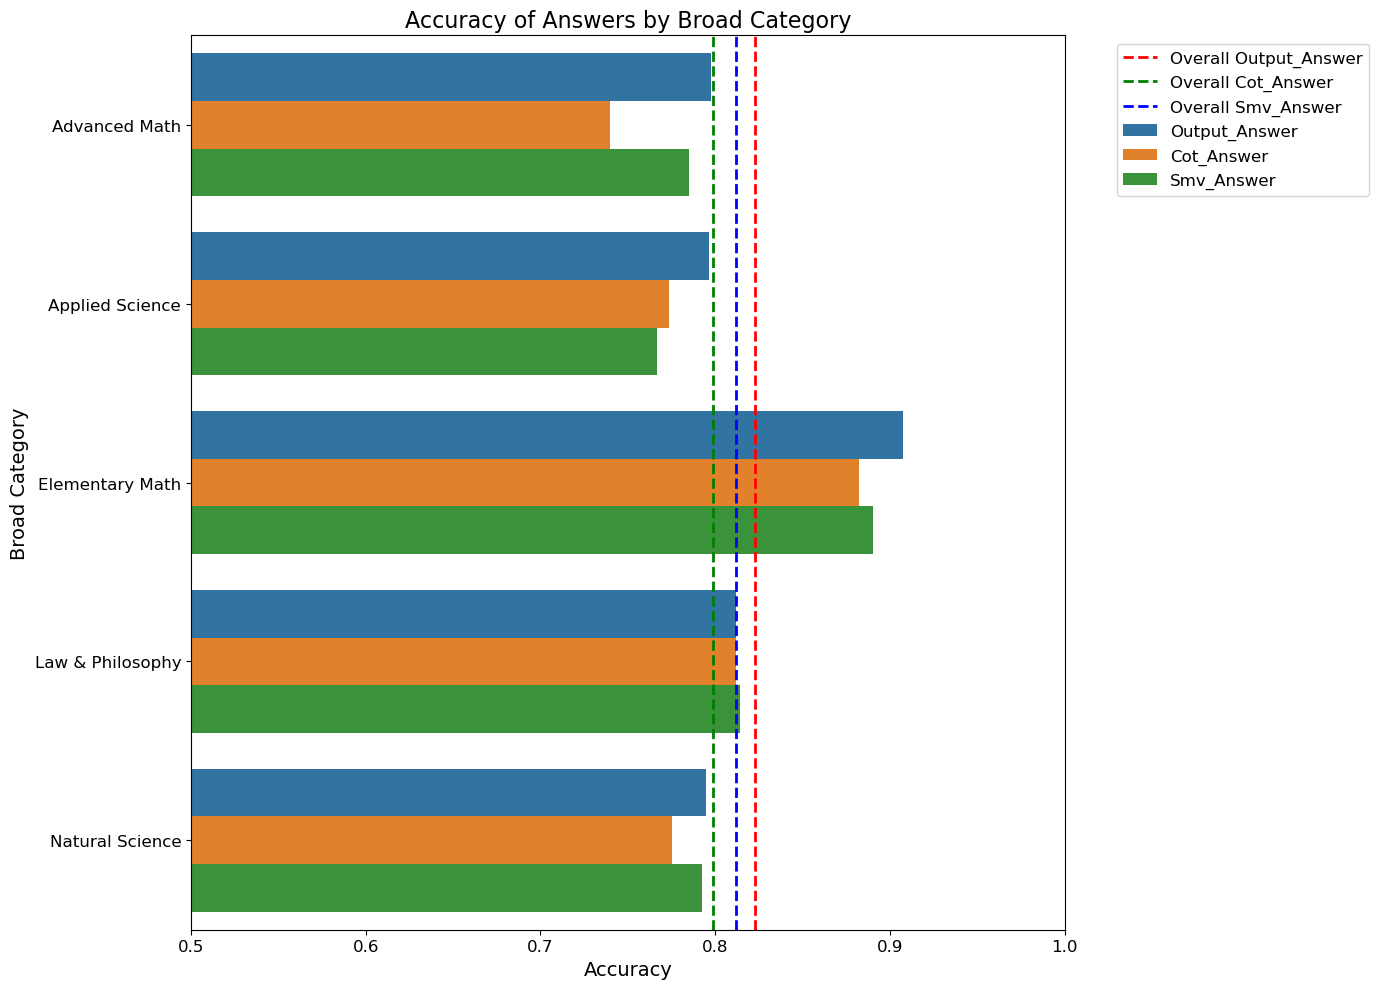

/tmp/ipykernel_582434/3680818807.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Accuracy", y="Category", hue="Answer Type", data=accuracies_df, ci=None)


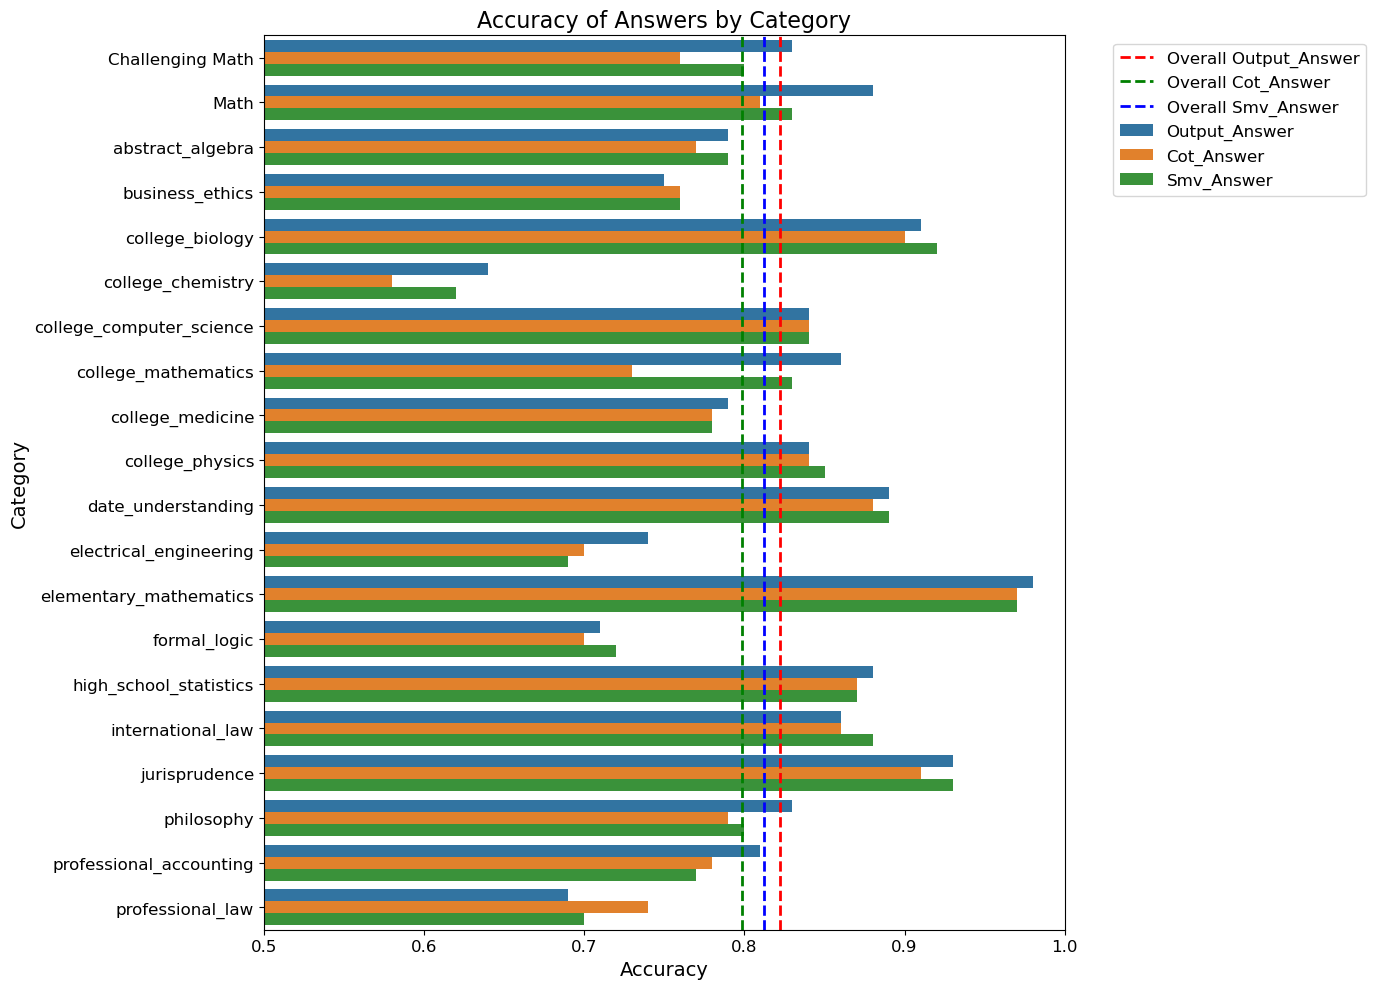

In [52]:
# Function to calculate accuracy
def calculate_accuracy(df, answer_column):
    return df.apply(lambda row: check_consistency_pair(row[answer_column], row['Correct_Answer']), axis=1).mean()

# Function to plot accuracies
def plot_accuracies_combined(df, answer_columns, groupby_column,figurename):
    accuracies_data = []
    overall_accuracies = {}
    # Define distinct colors for the overall performance lines
    line_colors = ['red', 'green', 'blue','yellow','black','brown']
    
    # Calculate overall accuracies for each answer type
    for answer_column in answer_columns:
        overall_accuracies[answer_column] = calculate_accuracy(df, answer_column)

    # Gather data for plotting
    for category, group_df in df.groupby(groupby_column):
        for answer_column in answer_columns:
            accuracy = calculate_accuracy(group_df, answer_column)
            accuracies_data.append({'Category': category, 'Answer Type': answer_column, 'Accuracy': accuracy})
    
    accuracies_df = pd.DataFrame(accuracies_data)
    
    # Plot
    plt.figure(figsize=(14, 10))  # Making the plot bigger
    sns.barplot(x="Accuracy", y="Category", hue="Answer Type", data=accuracies_df, ci=None)
    
    # Plot overall lines for each answer type with distinct colors
    for (answer_type, overall_accuracy), color in zip(overall_accuracies.items(), line_colors):
        plt.axvline(x=overall_accuracy, linestyle='--', color=color, label=f'Overall {answer_type}', lw=2)

    plt.title(f'Accuracy of Answers by {groupby_column}', fontsize=16)
    plt.xlabel('Accuracy', fontsize=14)
    plt.ylabel(groupby_column, fontsize=14)
    plt.xlim(0.5, 1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)  # Adjusting legend position
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.savefig(figurename)
    plt.show()
    
    
df_filter['Broad Category'] = df_filter['Category'].apply(map_category_to_broad)


# Plot accuracies for each Broad_category and then for Category, represented in a single plot for each
plot_accuracies_combined(df_filter, ["Output_Answer", "Cot_Answer", "Smv_Answer"], "Broad Category","bc.png")
plot_accuracies_combined(df_filter, ["Output_Answer", "Cot_Answer", "Smv_Answer"], "Category",'c.png')

# Plot accuracies for each Broad_category and Category

# check_accuracy(df_filter)

In [53]:
def create_new_column(df_filter, x,colname):
    # Convert x to a probability (0 to 1)
    probability = x / 100
    
    # Function to determine the value of the new column for each row
    def determine_value(row):
        if row['accuracy'] == 0:
            # If accuracy is 0, decide based on the given probability whether to choose Correct_Answer or Output_Answer
            return row['Correct_Answer'] if np.random.rand() < probability else row['Output_Answer']
        else:
            # If accuracy is not 0, just use the Output_Answer
            return row['Output_Answer']
    
    # Apply the function to each row to create the new column
    df_filter[colname] = df_filter.apply(determine_value, axis=1)
    
    return df_filter

# Example usage (assuming df_filter is your DataFrame and you want a 30% likelihood):
df_filter = create_new_column(df_filter, 2,'single_step_answer')

In [54]:
df_filter = create_new_column(df_filter, 2,'single_step_answer')
df_filter = create_new_column(df_filter, 5,'multi_step_answer')

In [55]:
def create_new_column_worse(df_filter, x,colname):
    # Convert x to a probability (0 to 1)
    probability = x / 100
    
    # Function to determine the value of the new column for each row
    def determine_value(row):
        if row['accuracy'] == 1:
            # If accuracy is 0, decide based on the given probability whether to choose Correct_Answer or Output_Answer
            return row['Cot_random_answer'] if np.random.rand() < probability else row['Output_Answer']
        else:
            # If accuracy is not 0, just use the Output_Answer
            return row['Output_Answer']
    
    # Apply the function to each row to create the new column
    df_filter[colname] = df_filter.apply(determine_value, axis=1)
    
    return df_filter

# Example usage (assuming df_filter is your DataFrame and you want a 30% likelihood):


In [56]:
df_filter = create_new_column(df_filter, 3,'whole_answer')

/tmp/ipykernel_582434/3680818807.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Accuracy", y="Category", hue="Answer Type", data=accuracies_df, ci=None)


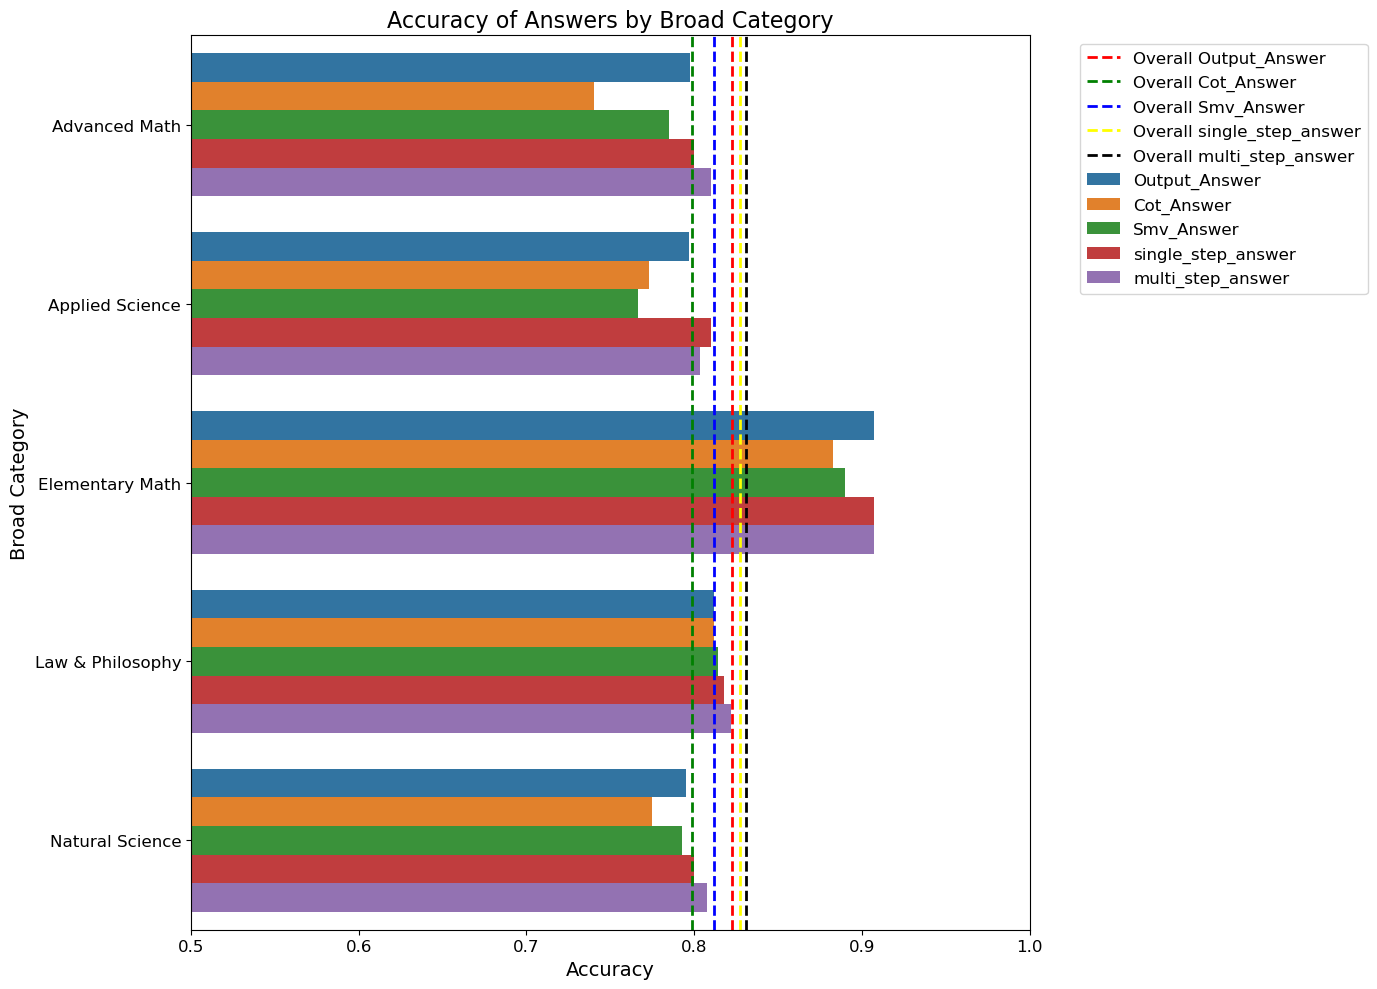

/tmp/ipykernel_582434/3680818807.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Accuracy", y="Category", hue="Answer Type", data=accuracies_df, ci=None)


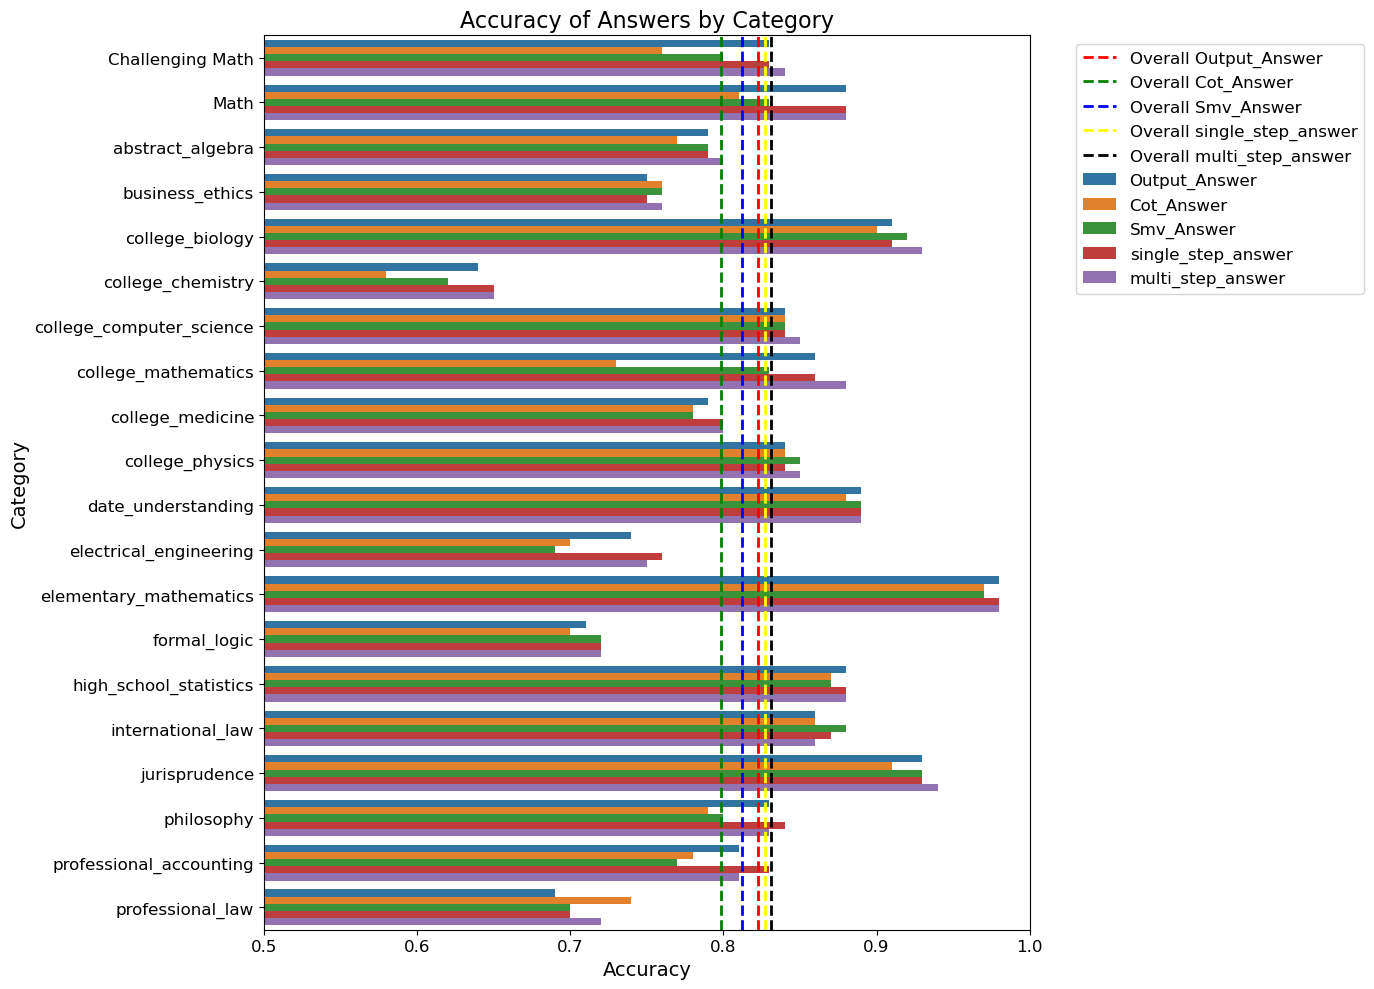

In [57]:
plot_accuracies_combined(df_filter, ["Output_Answer", "Cot_Answer", "Smv_Answer",'single_step_answer','multi_step_answer'], "Broad Category","bc.png")
plot_accuracies_combined(df_filter, ["Output_Answer", "Cot_Answer", "Smv_Answer",'single_step_answer','multi_step_answer'], "Category",'c.png')

In [24]:
df_filter['Output_Answer']

,index,Category,Question,Correct_Answer,Output_Answer,Consistency,Cot,Cot_Answer,Smv_Answer,Cot_random,Cot_random_answer,Match,avg_steps,cot_similarity,confidence_score,accuracy,Broad Category
0,276,jurisprudence,‘Law consists of set of principles or body of ...,B,B,True,NaN,B,B,Step 1: Understand the statement given. The st...,B,True,4.000000,0.902215,0.717405,1,Law & Philosophy
1,535,Math,you enter a weight loss challenge game and man...,c,c,True,NaN,c,c,step 1: Assume the initial body weight is 100 ...,c,True,5.666667,0.902215,0.692895,1,Elementary Math
2,540,Math,"wink , inc . follows a certain procedure that ...",a,a,True,NaN,a,a,step 1: Identify the probability of task 1 bei...,a,True,7.000000,0.902215,0.681691,1,Elementary Math
3,456,Challenging Math,what will be the compound interest on rs . 250...,a,a,True,NaN,a,a,step 1: Identify the formula for compound inte...,a,True,7.000000,0.902215,0.681691,1,Advanced Math
4,405,Challenging Math,what quantity of water should be added to redu...,a,a,True,NaN,a,a,step 1: Identify the initial volume and concen...,a,True,4.000000,0.902215,0.717405,1,Advanced Math
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,639,formal_logic,Construct a complete truth table for the foll...,D,B,True,NaN,B,B,step 1: Identify the premises and conclusion. ...,B,False,5.000000,0.902215,0.700738,0,Advanced Math
1996,607,formal_logic,Construct a complete truth table for the foll...,B,A,False,step 1: Identify the premises and conclusion. ...,A,"B) Invalid. Counterexample when P, R, and Q ar...",step 1: Identify the premises and conclusion. ...,"B) Invalid. Counterexample when P, R, and Q ar...",False,2.666667,0.365352,0.246784,0,Advanced Math
1997,630,formal_logic,Construct a complete truth table for the foll...,B,A) Valid,False,step 1: Identify the premises and conclusion. ...,A) Valid,"B) Invalid. Counterexample when P, R, and Q ar...",step 1: Identify the premises and conclusion. ...,A) Valid,False,4.333333,0.265736,0.165502,0,Advanced Math
1998,660,formal_logic,Construct a complete truth table for the foll...,B,A) Valid,False,step 1: Identify the premises and conclusion. ...,"B) Invalid. Counterexample when P, R, and Q ar...","B) Invalid. Counterexample when P, R, and Q ar...",step 1: Identify the premises and conclusion. ...,"B) Invalid. Counterexample when P, R, and Q ar...",False,8.666667,0.302710,0.139365,0,Advanced Math


### Confidence score

In [84]:
df_filter

,index,Category,Question,Correct_Answer,Output_Answer,Consistency,Cot,Cot_Answer,Smv_Answer,Cot_random,Cot_random_answer,Match,avg_steps,cot_similarity,confidence_score,accuracy
0,276,jurisprudence,‘Law consists of set of principles or body of ...,B,B,True,NaN,B,B,Step 1: Understand the statement given. The st...,B,True,4.000000,0.902215,0.717405,1
1,535,Math,you enter a weight loss challenge game and man...,c,c,True,NaN,c,c,step 1: Assume the initial body weight is 100 ...,c,True,5.666667,0.902215,0.692895,1
2,540,Math,"wink , inc . follows a certain procedure that ...",a,a,True,NaN,a,a,step 1: Identify the probability of task 1 bei...,a,True,7.000000,0.902215,0.681691,1
3,456,Challenging Math,what will be the compound interest on rs . 250...,a,a,True,NaN,a,a,step 1: Identify the formula for compound inte...,a,True,7.000000,0.902215,0.681691,1
4,405,Challenging Math,what quantity of water should be added to redu...,a,a,True,NaN,a,a,step 1: Identify the initial volume and concen...,a,True,4.000000,0.902215,0.717405,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,639,formal_logic,Construct a complete truth table for the foll...,D,B,True,NaN,B,B,step 1: Identify the premises and conclusion. ...,B,False,5.000000,0.902215,0.700738,0
1996,607,formal_logic,Construct a complete truth table for the foll...,B,A,False,step 1: Identify the premises and conclusion. ...,A,"B) Invalid. Counterexample when P, R, and Q ar...",step 1: Identify the premises and conclusion. ...,"B) Invalid. Counterexample when P, R, and Q ar...",False,2.666667,0.365352,0.246784,0
1997,630,formal_logic,Construct a complete truth table for the foll...,B,A) Valid,False,step 1: Identify the premises and conclusion. ...,A) Valid,"B) Invalid. Counterexample when P, R, and Q ar...",step 1: Identify the premises and conclusion. ...,A) Valid,False,4.333333,0.265736,0.165502,0
1998,660,formal_logic,Construct a complete truth table for the foll...,B,A) Valid,False,step 1: Identify the premises and conclusion. ...,"B) Invalid. Counterexample when P, R, and Q ar...","B) Invalid. Counterexample when P, R, and Q ar...",step 1: Identify the premises and conclusion. ...,"B) Invalid. Counterexample when P, R, and Q ar...",False,8.666667,0.302710,0.139365,0


In [52]:
import math
df_filter['Confidence_Score'] = df_filter.apply(lambda row: get_confidence_score_filter(
    row['Consistency'], row['cot_similarity'], row['avg_steps'], alpha=0.5, beta=0.5, gamma=0.5
), axis=1)

In [60]:
df_all = df_final.merge(df_filter,left_on='raw_cot',right_on='Cot')

In [61]:
df_all = df_all.reset_index(drop=True)

In [62]:
def calculate_hallu_steps(row):
    if row["Hallu Seq"] and row["Hallu Seq"][-1] == "Yes":
        # Number of "No" in the sequence
        no_count = row["Hallu Seq"].count("No")
        # Calculate hallucinated steps
        return row["avg_steps"] - no_count
    return 0

# Apply the function to create a new column
df_all["hallu_steps"] = df_all.apply(calculate_hallu_steps, axis=1)

In [67]:
steps = 10
df_all["confidence_score"] = df_all.apply(lambda row: get_confidence_score(row['confidence_score'],row["hallu_steps"], row["avg_steps"]), axis=1)

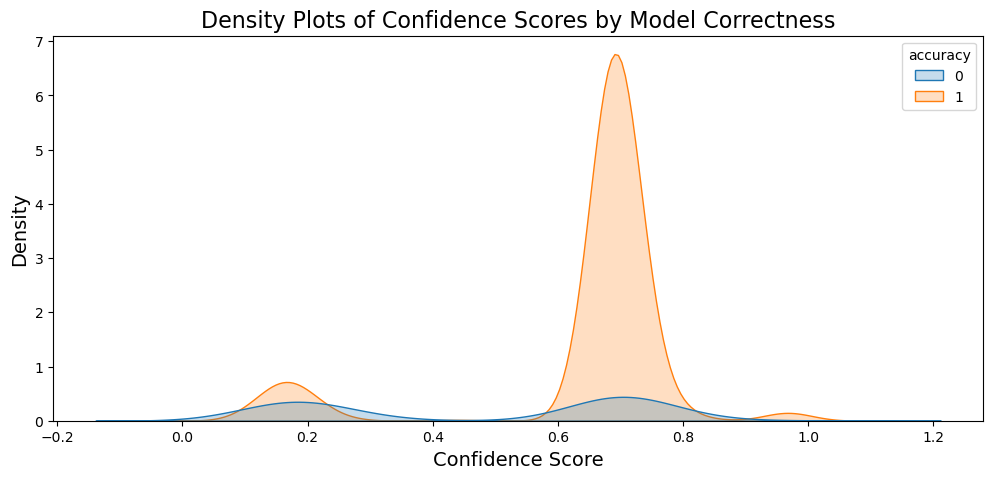

In [59]:
# KDE Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 1, 1)  # Only one subplot in this case
sns.kdeplot(data=df_filter, x="confidence_score", hue="accuracy", fill=True)

# Updating the title to more accurately describe the plot and enlarging font sizes
plt.title("Density Plots of Confidence Scores by Model Correctness", fontsize=16)

# Enlarging axis label fonts
plt.xlabel("Confidence Score", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Enlarging the legend font
# plt.legend(title='Model Correctness', title_fontsize='13', fontsize='12')

plt.savefig('cs1.png')